In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [2]:
class EfficientNetB0_AudioClassifier(nn.Module):
    def __init__(self, num_classes, input_channels=1, pretrained=False):
        super().__init__()
        
        # THAY ĐỔI 1: Tải kiến trúc EfficientNet-B0 với weights=None
        weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        self.efficientnet = models.efficientnet_b0(weights=weights)

        # 1. Điều chỉnh lớp Conv đầu tiên để chấp nhận đầu vào 1 kênh (spectrogram)
        original_conv = self.efficientnet.features[0][0]
        new_first_conv = nn.Conv2d(
            in_channels=input_channels,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=False
        )
        self.efficientnet.features[0][0] = new_first_conv

        # 2. Thay thế lớp phân loại cuối cùng
        # Lấy số features đầu vào của classifier gốc (cho B0 là 1280)
        num_ftrs = self.efficientnet.classifier[1].in_features
        # Thay thế classifier gốc bằng một lớp Linear mới
        self.efficientnet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.efficientnet(x)


def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [3]:
class InsectSpectrogramDataset(Dataset):
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'
        
        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]
        
        try:
            spectrogram = torch.load(file_path)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1


In [4]:
METADATA_PATH = r'C:\Users\PC\Downloads\InsectSound1000_Mel\metadata_Mel.csv'
DATA_DIR = r'C:\Users\PC\Downloads\InsectSound1000_Mel\MelSpectrograms'

In [5]:
class TimeShift(torch.nn.Module):
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

train_transform = T.Compose([
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    TimeShift(p=0.5, max_shift_percent=0.4),
    SpecNoise(p=0.3, noise_level=0.03),
])

val_transform = None

def mixup_data(x, y, alpha=0.4, use_cuda=True):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device if use_cuda else 'cpu')
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [6]:
if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [8]:
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

# Cập nhật đường dẫn để lưu kết quả của EfficientNet-B0
CHECKPOINT_DIR = r'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0'
LOG_CSV_PATH = r'C:\Users\PC\Downloads\InsectSound1000_Mel\training_log_efficientnet_b0.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Khởi tạo mô hình mới
model = EfficientNetB0_AudioClassifier(num_classes=num_classes, pretrained=False).to(device)
total_params, trainable_params = count_parameters(model)
print(f"Khởi tạo mô hình EfficientNet-B0 (từ đầu) với {total_params/1e6:.2f}M tham số.")


Khởi tạo mô hình EfficientNet-B0 (từ đầu) với 4.02M tham số.


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

log_header = ['epoch', 'train_loss', 'val_loss', 'learning_rate', 'accuracy', 'precision', 'recall', 'f1']
with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

best_val_f1 = 0.0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for inputs, labels in progress_bar:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels: continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss   = val_loss / len(val_dataset)
    accuracy  = accuracy_score(val_labels, val_preds)
    precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    recall    = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    f1        = f1_score(val_labels, val_preds, average='micro', zero_division=0)
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    log_data = [epoch + 1, epoch_train_loss, epoch_val_loss, current_lr, accuracy, precision, recall, f1]
    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        csv.writer(f).writerow(log_data)

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")



Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0' và log tại 'C:\Users\PC\Downloads\InsectSound1000_Mel\training_log_efficientnet_b0.csv'


Epoch 1/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.1389 | Val Loss: 0.8096
  Accuracy: 0.7110 | Precision: 0.7110 | Recall: 0.7110 | F1: 0.7110
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.7110)



Epoch 2/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 0.8092 | Val Loss: 0.6451
  Accuracy: 0.7983 | Precision: 0.7983 | Recall: 0.7983 | F1: 0.7983
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.7983)



Epoch 3/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 0.7232 | Val Loss: 0.4356
  Accuracy: 0.8516 | Precision: 0.8516 | Recall: 0.8516 | F1: 0.8516
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.8516)



Epoch 4/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 0.6652 | Val Loss: 0.5832
  Accuracy: 0.8056 | Precision: 0.8056 | Recall: 0.8056 | F1: 0.8056


Epoch 5/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 0.6249 | Val Loss: 0.3662
  Accuracy: 0.8731 | Precision: 0.8731 | Recall: 0.8731 | F1: 0.8731
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.8731)



Epoch 6/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 0.5861 | Val Loss: 0.4481
  Accuracy: 0.8626 | Precision: 0.8626 | Recall: 0.8626 | F1: 0.8626


Epoch 7/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.5702 | Val Loss: 0.4596
  Accuracy: 0.8729 | Precision: 0.8729 | Recall: 0.8729 | F1: 0.8729


Epoch 8/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.5463 | Val Loss: 0.6153
  Accuracy: 0.7996 | Precision: 0.7996 | Recall: 0.7996 | F1: 0.7996


Epoch 9/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.5236 | Val Loss: 0.3017
  Accuracy: 0.8960 | Precision: 0.8960 | Recall: 0.8960 | F1: 0.8960
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.8960)



Epoch 10/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.5244 | Val Loss: 0.3096
  Accuracy: 0.9004 | Precision: 0.9004 | Recall: 0.9004 | F1: 0.9004
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9004)



Epoch 11/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.4980 | Val Loss: 0.8854
  Accuracy: 0.7307 | Precision: 0.7307 | Recall: 0.7307 | F1: 0.7307


Epoch 12/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.4839 | Val Loss: 1.1703
  Accuracy: 0.6795 | Precision: 0.6795 | Recall: 0.6795 | F1: 0.6795


Epoch 13/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.4691 | Val Loss: 0.5214
  Accuracy: 0.8322 | Precision: 0.8322 | Recall: 0.8322 | F1: 0.8322


Epoch 14/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.4654 | Val Loss: 0.3105
  Accuracy: 0.9048 | Precision: 0.9048 | Recall: 0.9048 | F1: 0.9048
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9048)



Epoch 15/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.4495 | Val Loss: 0.3130
  Accuracy: 0.9013 | Precision: 0.9013 | Recall: 0.9013 | F1: 0.9013


Epoch 16/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.4434 | Val Loss: 0.3101
  Accuracy: 0.8994 | Precision: 0.8994 | Recall: 0.8994 | F1: 0.8994


Epoch 17/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.4288 | Val Loss: 0.3303
  Accuracy: 0.8924 | Precision: 0.8924 | Recall: 0.8924 | F1: 0.8924


Epoch 18/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.4380 | Val Loss: 0.2883
  Accuracy: 0.9094 | Precision: 0.9094 | Recall: 0.9094 | F1: 0.9094
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9094)



Epoch 19/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.4270 | Val Loss: 0.4760
  Accuracy: 0.8523 | Precision: 0.8523 | Recall: 0.8523 | F1: 0.8523


Epoch 20/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.4216 | Val Loss: 0.2875
  Accuracy: 0.9215 | Precision: 0.9215 | Recall: 0.9215 | F1: 0.9215
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9215)



Epoch 21/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.4118 | Val Loss: 0.4177
  Accuracy: 0.8679 | Precision: 0.8679 | Recall: 0.8679 | F1: 0.8679


Epoch 22/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.4133 | Val Loss: 0.2661
  Accuracy: 0.9131 | Precision: 0.9131 | Recall: 0.9131 | F1: 0.9131


Epoch 23/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.3836 | Val Loss: 0.4479
  Accuracy: 0.8614 | Precision: 0.8614 | Recall: 0.8614 | F1: 0.8614


Epoch 24/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.3893 | Val Loss: 0.3385
  Accuracy: 0.8931 | Precision: 0.8931 | Recall: 0.8931 | F1: 0.8931


Epoch 25/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.3877 | Val Loss: 0.3649
  Accuracy: 0.8851 | Precision: 0.8851 | Recall: 0.8851 | F1: 0.8851


Epoch 26/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.3816 | Val Loss: 0.3014
  Accuracy: 0.9081 | Precision: 0.9081 | Recall: 0.9081 | F1: 0.9081


Epoch 27/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.3699 | Val Loss: 0.2658
  Accuracy: 0.9195 | Precision: 0.9195 | Recall: 0.9195 | F1: 0.9195


Epoch 28/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.3726 | Val Loss: 0.4702
  Accuracy: 0.8562 | Precision: 0.8562 | Recall: 0.8562 | F1: 0.8562


Epoch 29/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.3603 | Val Loss: 0.2769
  Accuracy: 0.9144 | Precision: 0.9144 | Recall: 0.9144 | F1: 0.9144


Epoch 30/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.3697 | Val Loss: 0.3666
  Accuracy: 0.8854 | Precision: 0.8854 | Recall: 0.8854 | F1: 0.8854


Epoch 31/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.3574 | Val Loss: 0.3009
  Accuracy: 0.9111 | Precision: 0.9111 | Recall: 0.9111 | F1: 0.9111


Epoch 32/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.3482 | Val Loss: 0.2777
  Accuracy: 0.9156 | Precision: 0.9156 | Recall: 0.9156 | F1: 0.9156


Epoch 33/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.3547 | Val Loss: 0.3656
  Accuracy: 0.8924 | Precision: 0.8924 | Recall: 0.8924 | F1: 0.8924


Epoch 34/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.3351 | Val Loss: 0.4398
  Accuracy: 0.8749 | Precision: 0.8749 | Recall: 0.8749 | F1: 0.8749


Epoch 35/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.3580 | Val Loss: 0.3036
  Accuracy: 0.9150 | Precision: 0.9150 | Recall: 0.9150 | F1: 0.9150


Epoch 36/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.3434 | Val Loss: 0.2940
  Accuracy: 0.9196 | Precision: 0.9196 | Recall: 0.9196 | F1: 0.9196


Epoch 37/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.3447 | Val Loss: 0.2962
  Accuracy: 0.9149 | Precision: 0.9149 | Recall: 0.9149 | F1: 0.9149


Epoch 38/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.3488 | Val Loss: 0.3382
  Accuracy: 0.9004 | Precision: 0.9004 | Recall: 0.9004 | F1: 0.9004


Epoch 39/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.3521 | Val Loss: 0.3371
  Accuracy: 0.9019 | Precision: 0.9019 | Recall: 0.9019 | F1: 0.9019


Epoch 40/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.3223 | Val Loss: 0.2575
  Accuracy: 0.9243 | Precision: 0.9243 | Recall: 0.9243 | F1: 0.9243
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9243)



Epoch 41/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.3430 | Val Loss: 0.3423
  Accuracy: 0.9133 | Precision: 0.9133 | Recall: 0.9133 | F1: 0.9133


Epoch 42/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.3239 | Val Loss: 0.3313
  Accuracy: 0.9061 | Precision: 0.9061 | Recall: 0.9061 | F1: 0.9061


Epoch 43/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.3208 | Val Loss: 0.2790
  Accuracy: 0.9213 | Precision: 0.9213 | Recall: 0.9213 | F1: 0.9213


Epoch 44/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.3185 | Val Loss: 0.2931
  Accuracy: 0.9183 | Precision: 0.9183 | Recall: 0.9183 | F1: 0.9183


Epoch 45/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.3365 | Val Loss: 0.2658
  Accuracy: 0.9259 | Precision: 0.9259 | Recall: 0.9259 | F1: 0.9259
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9259)



Epoch 46/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.3237 | Val Loss: 0.2921
  Accuracy: 0.9172 | Precision: 0.9172 | Recall: 0.9172 | F1: 0.9172


Epoch 47/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.3184 | Val Loss: 0.2731
  Accuracy: 0.9250 | Precision: 0.9250 | Recall: 0.9250 | F1: 0.9250


Epoch 48/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.3265 | Val Loss: 0.2889
  Accuracy: 0.9206 | Precision: 0.9206 | Recall: 0.9206 | F1: 0.9206


Epoch 49/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.3198 | Val Loss: 0.2714
  Accuracy: 0.9251 | Precision: 0.9251 | Recall: 0.9251 | F1: 0.9251


Epoch 50/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.3177 | Val Loss: 0.2759
  Accuracy: 0.9206 | Precision: 0.9206 | Recall: 0.9206 | F1: 0.9206


Epoch 51/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.3074 | Val Loss: 0.2994
  Accuracy: 0.9218 | Precision: 0.9218 | Recall: 0.9218 | F1: 0.9218


Epoch 52/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.3043 | Val Loss: 0.2831
  Accuracy: 0.9235 | Precision: 0.9235 | Recall: 0.9235 | F1: 0.9235


Epoch 53/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.2960 | Val Loss: 0.2956
  Accuracy: 0.9185 | Precision: 0.9185 | Recall: 0.9185 | F1: 0.9185


Epoch 54/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.3103 | Val Loss: 0.2692
  Accuracy: 0.9243 | Precision: 0.9243 | Recall: 0.9243 | F1: 0.9243


Epoch 55/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.2982 | Val Loss: 0.2736
  Accuracy: 0.9274 | Precision: 0.9274 | Recall: 0.9274 | F1: 0.9274
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9274)



Epoch 56/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.3066 | Val Loss: 0.2804
  Accuracy: 0.9253 | Precision: 0.9253 | Recall: 0.9253 | F1: 0.9253


Epoch 57/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.2973 | Val Loss: 0.3285
  Accuracy: 0.9200 | Precision: 0.9200 | Recall: 0.9200 | F1: 0.9200


Epoch 58/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.3049 | Val Loss: 0.2673
  Accuracy: 0.9285 | Precision: 0.9285 | Recall: 0.9285 | F1: 0.9285
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9285)



Epoch 59/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.3103 | Val Loss: 0.2789
  Accuracy: 0.9237 | Precision: 0.9237 | Recall: 0.9237 | F1: 0.9237


Epoch 60/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.3052 | Val Loss: 0.2966
  Accuracy: 0.9195 | Precision: 0.9195 | Recall: 0.9195 | F1: 0.9195


Epoch 61/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.2957 | Val Loss: 0.2771
  Accuracy: 0.9231 | Precision: 0.9231 | Recall: 0.9231 | F1: 0.9231


Epoch 62/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.2914 | Val Loss: 0.2632
  Accuracy: 0.9302 | Precision: 0.9302 | Recall: 0.9302 | F1: 0.9302
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9302)



Epoch 63/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.3018 | Val Loss: 0.3012
  Accuracy: 0.9250 | Precision: 0.9250 | Recall: 0.9250 | F1: 0.9250


Epoch 64/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.2971 | Val Loss: 0.2650
  Accuracy: 0.9284 | Precision: 0.9284 | Recall: 0.9284 | F1: 0.9284


Epoch 65/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.2976 | Val Loss: 0.2715
  Accuracy: 0.9284 | Precision: 0.9284 | Recall: 0.9284 | F1: 0.9284


Epoch 66/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.2881 | Val Loss: 0.2872
  Accuracy: 0.9316 | Precision: 0.9316 | Recall: 0.9316 | F1: 0.9316
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9316)



Epoch 67/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.2823 | Val Loss: 0.2729
  Accuracy: 0.9268 | Precision: 0.9268 | Recall: 0.9268 | F1: 0.9268


Epoch 68/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.2911 | Val Loss: 0.2662
  Accuracy: 0.9313 | Precision: 0.9313 | Recall: 0.9313 | F1: 0.9313


Epoch 69/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.2951 | Val Loss: 0.2692
  Accuracy: 0.9307 | Precision: 0.9307 | Recall: 0.9307 | F1: 0.9307


Epoch 70/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.2844 | Val Loss: 0.2701
  Accuracy: 0.9313 | Precision: 0.9313 | Recall: 0.9313 | F1: 0.9313


Epoch 71/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.2864 | Val Loss: 0.2899
  Accuracy: 0.9278 | Precision: 0.9278 | Recall: 0.9278 | F1: 0.9278


Epoch 72/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.2845 | Val Loss: 0.2638
  Accuracy: 0.9309 | Precision: 0.9309 | Recall: 0.9309 | F1: 0.9309


Epoch 73/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.2841 | Val Loss: 0.2738
  Accuracy: 0.9275 | Precision: 0.9275 | Recall: 0.9275 | F1: 0.9275


Epoch 74/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.2794 | Val Loss: 0.2575
  Accuracy: 0.9355 | Precision: 0.9355 | Recall: 0.9355 | F1: 0.9355
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9355)



Epoch 75/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.2847 | Val Loss: 0.2635
  Accuracy: 0.9340 | Precision: 0.9340 | Recall: 0.9340 | F1: 0.9340


Epoch 76/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.2860 | Val Loss: 0.2577
  Accuracy: 0.9343 | Precision: 0.9343 | Recall: 0.9343 | F1: 0.9343


Epoch 77/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.2821 | Val Loss: 0.2732
  Accuracy: 0.9323 | Precision: 0.9323 | Recall: 0.9323 | F1: 0.9323


Epoch 78/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.2783 | Val Loss: 0.2674
  Accuracy: 0.9304 | Precision: 0.9304 | Recall: 0.9304 | F1: 0.9304


Epoch 79/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.2750 | Val Loss: 0.2612
  Accuracy: 0.9325 | Precision: 0.9325 | Recall: 0.9325 | F1: 0.9325


Epoch 80/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.2850 | Val Loss: 0.2537
  Accuracy: 0.9337 | Precision: 0.9337 | Recall: 0.9337 | F1: 0.9337


Epoch 81/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.2782 | Val Loss: 0.2567
  Accuracy: 0.9348 | Precision: 0.9348 | Recall: 0.9348 | F1: 0.9348


Epoch 82/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.2780 | Val Loss: 0.2628
  Accuracy: 0.9354 | Precision: 0.9354 | Recall: 0.9354 | F1: 0.9354


Epoch 83/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.2819 | Val Loss: 0.2672
  Accuracy: 0.9336 | Precision: 0.9336 | Recall: 0.9336 | F1: 0.9336


Epoch 84/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.2776 | Val Loss: 0.2658
  Accuracy: 0.9336 | Precision: 0.9336 | Recall: 0.9336 | F1: 0.9336


Epoch 85/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.2776 | Val Loss: 0.2608
  Accuracy: 0.9343 | Precision: 0.9343 | Recall: 0.9343 | F1: 0.9343


Epoch 86/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.2761 | Val Loss: 0.2770
  Accuracy: 0.9340 | Precision: 0.9340 | Recall: 0.9340 | F1: 0.9340


Epoch 87/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.2694 | Val Loss: 0.2590
  Accuracy: 0.9351 | Precision: 0.9351 | Recall: 0.9351 | F1: 0.9351


Epoch 88/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.2763 | Val Loss: 0.2676
  Accuracy: 0.9342 | Precision: 0.9342 | Recall: 0.9342 | F1: 0.9342


Epoch 89/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.2888 | Val Loss: 0.2539
  Accuracy: 0.9363 | Precision: 0.9363 | Recall: 0.9363 | F1: 0.9363
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9363)



Epoch 90/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.2664 | Val Loss: 0.2567
  Accuracy: 0.9368 | Precision: 0.9368 | Recall: 0.9368 | F1: 0.9368
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_efficientnet_b0\best_model.pth' (F1: 0.9368)



Epoch 91/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.2705 | Val Loss: 0.2595
  Accuracy: 0.9360 | Precision: 0.9360 | Recall: 0.9360 | F1: 0.9360


Epoch 92/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.2747 | Val Loss: 0.2585
  Accuracy: 0.9359 | Precision: 0.9359 | Recall: 0.9359 | F1: 0.9359


Epoch 93/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.2830 | Val Loss: 0.2633
  Accuracy: 0.9358 | Precision: 0.9358 | Recall: 0.9358 | F1: 0.9358


Epoch 94/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.2717 | Val Loss: 0.2719
  Accuracy: 0.9344 | Precision: 0.9344 | Recall: 0.9344 | F1: 0.9344


Epoch 95/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.2743 | Val Loss: 0.2624
  Accuracy: 0.9355 | Precision: 0.9355 | Recall: 0.9355 | F1: 0.9355


Epoch 96/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.2707 | Val Loss: 0.2533
  Accuracy: 0.9362 | Precision: 0.9362 | Recall: 0.9362 | F1: 0.9362


Epoch 97/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.2798 | Val Loss: 0.2634
  Accuracy: 0.9352 | Precision: 0.9352 | Recall: 0.9352 | F1: 0.9352


Epoch 98/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.2886 | Val Loss: 0.2804
  Accuracy: 0.9325 | Precision: 0.9325 | Recall: 0.9325 | F1: 0.9325


Epoch 99/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.2763 | Val Loss: 0.2545
  Accuracy: 0.9352 | Precision: 0.9352 | Recall: 0.9352 | F1: 0.9352


Epoch 100/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.2768 | Val Loss: 0.2555
  Accuracy: 0.9362 | Precision: 0.9362 | Recall: 0.9362 | F1: 0.9362

✅ Hoàn tất huấn luyện!


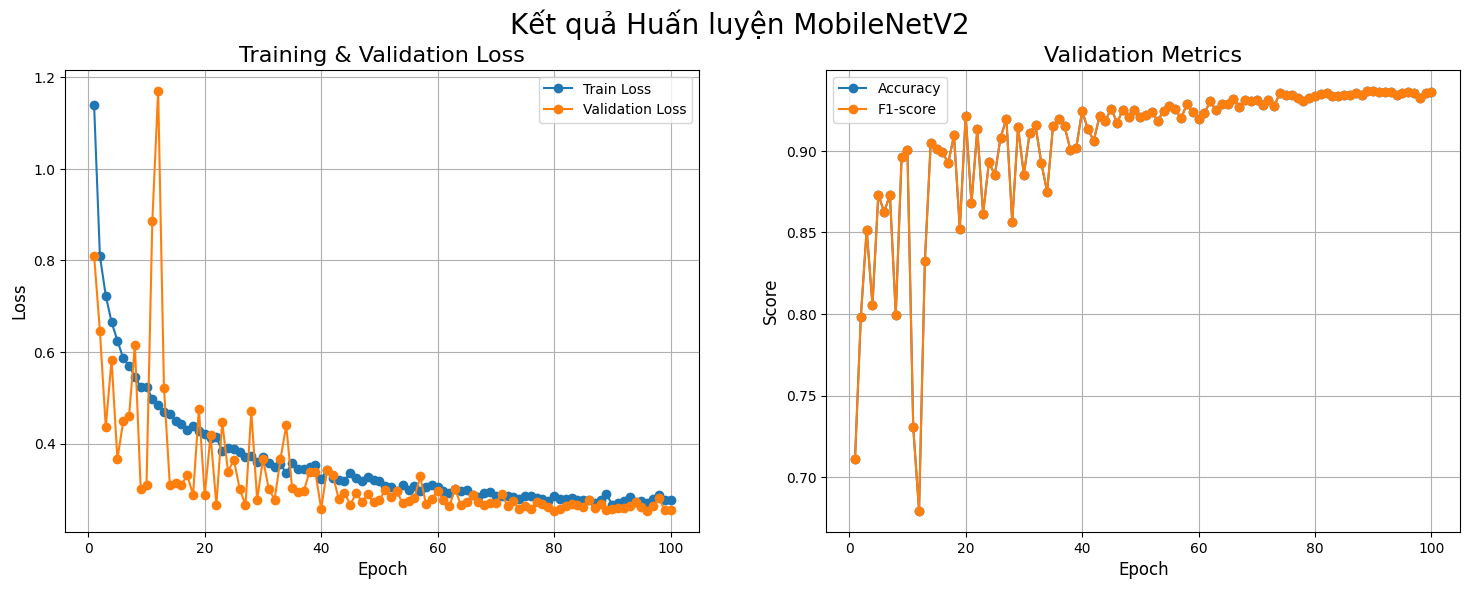


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


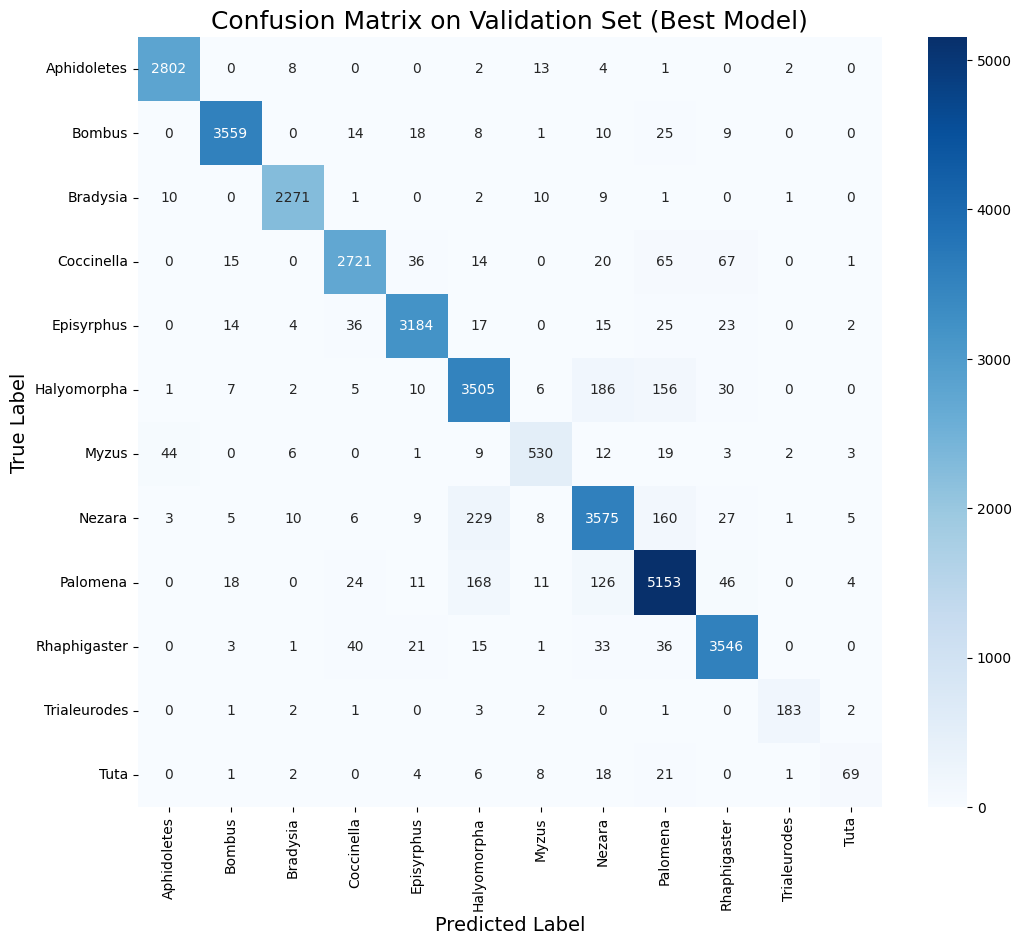

In [10]:
log_df = pd.read_csv(LOG_CSV_PATH)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['f1'], label='F1-score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện MobileNetV2', fontsize=20)
plt.show()

best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.class_names,
            yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix on Validation Set (Best Model)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()